In [75]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')


df = pd.read_excel('./training.xlsx')

# Save a copy of the raw data
df_raw = df.copy()

print(f"Number of unique authors: {df['author_id'].nunique()}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sirui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sirui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of unique authors: 15


Data preprocessing

Handle missing data

In [76]:
# Check missing values
print("Missing values before preprocessing:")
print(df.isnull().sum())


df['video_description'] = df['video_description'].fillna('').astype(str)  # For text features
df['video_definition'] = df['video_definition'].fillna('unknown')         # For categorical features
df['video_format'] = df['video_format'].fillna('unknown')                 # For categorical features
df['video_create_date'] = pd.to_datetime(df['video_create_date'], unit='s')
df['hour'] = df['video_create_date'].dt.hour

numerical_features = ['author_follower_count', 'video_play_count', 'video_comment_count', 
                      'video_heart_count', 'video_share_count']
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

print("\nMissing values after preprocessing:")
print(df.isnull().sum())


Missing values before preprocessing:
video_id                    0
author_id                   0
author_follower_count       0
author_following_count      0
author_total_heart_count    0
author_total_video_count    0
video_create_date           0
video_description           9
video_definition            4
video_format                4
video_comment_count         0
video_heart_count           0
video_play_count            0
video_share_count           0
dtype: int64

Missing values after preprocessing:
video_id                    0
author_id                   0
author_follower_count       0
author_following_count      0
author_total_heart_count    0
author_total_video_count    0
video_create_date           0
video_description           0
video_definition            0
video_format                0
video_comment_count         0
video_heart_count           0
video_play_count            0
video_share_count           0
hour                        0
dtype: int64


Handle outliers

In [77]:
df_raw['raw_video_play_count'] = df['video_play_count']

# Cap outliers at the 99th percentile
for col in numerical_features:
    upper_limit = df[col].quantile(0.99)
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])


 Text Preprocessing and Sentiment Analysis

In [78]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    words = text.split()      # Tokenize into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)    # Reconstruct text

# Apply preprocessing
df['processed_description'] = df['video_description'].apply(preprocess_text)

df_raw['raw_word_count'] = df['video_description'].apply(lambda x: len(str(x).split()))
df['word_count'] = df['processed_description'].apply(lambda x: len(str(x).split()))

# Sentiment Analysis
df['sentiment_polarity'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['sentiment_subjectivity'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Topic Modeling Using LDA
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['processed_description'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic_matrix = lda.fit_transform(text_matrix)
df['topic'] = topic_matrix.argmax(axis=1)

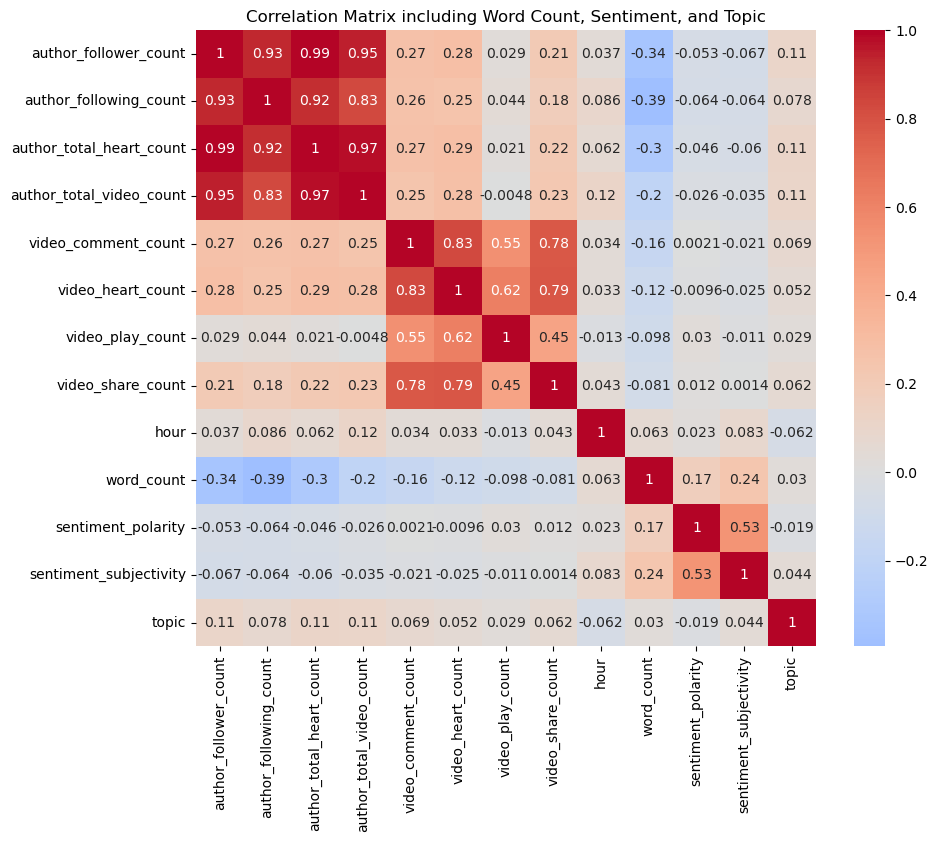

In [79]:
columns_not_in_corr = ['author_id', 'video_id', 'video_description','video_definition',	'video_format']


df_for_corr = df.drop(columns=columns_not_in_corr).select_dtypes(include=['number'])


# Convert all remaining columns to numeric
df_for_corr = df_for_corr.apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix
corr = df_for_corr.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix including Word Count, Sentiment, and Topic')
plt.show()

Feature scaling

In [80]:
# Save raw engagement ratio for comparison
df_raw['raw_engagement_ratio'] = (df_raw['video_play_count'] + df_raw['video_comment_count'] + 
                                  df_raw['video_heart_count'] + df_raw['video_share_count']) / (df_raw['author_follower_count'] + 1e-3)


df['engagement_ratio'] = (df['video_play_count'] + df['video_comment_count'] +
                          df['video_heart_count'] + df['video_share_count']) / (df['author_follower_count'] + 1e-3)


scaler = StandardScaler()
scaled_features = numerical_features + ['engagement_ratio']
df[scaled_features] = scaler.fit_transform(df[scaled_features])


Comparison data-preprocessing

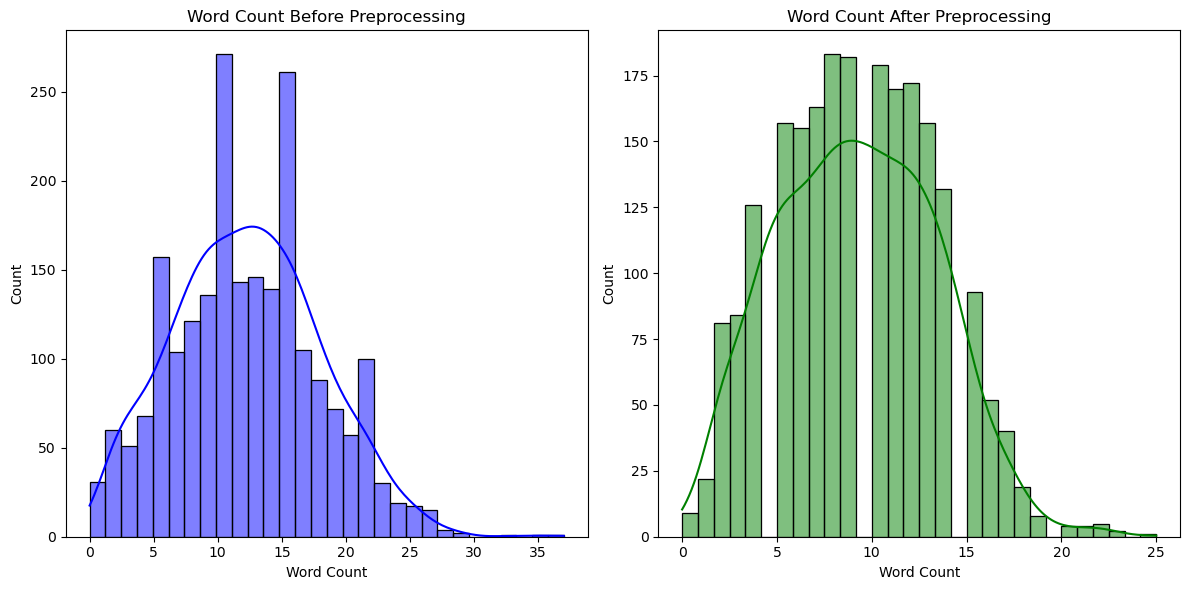

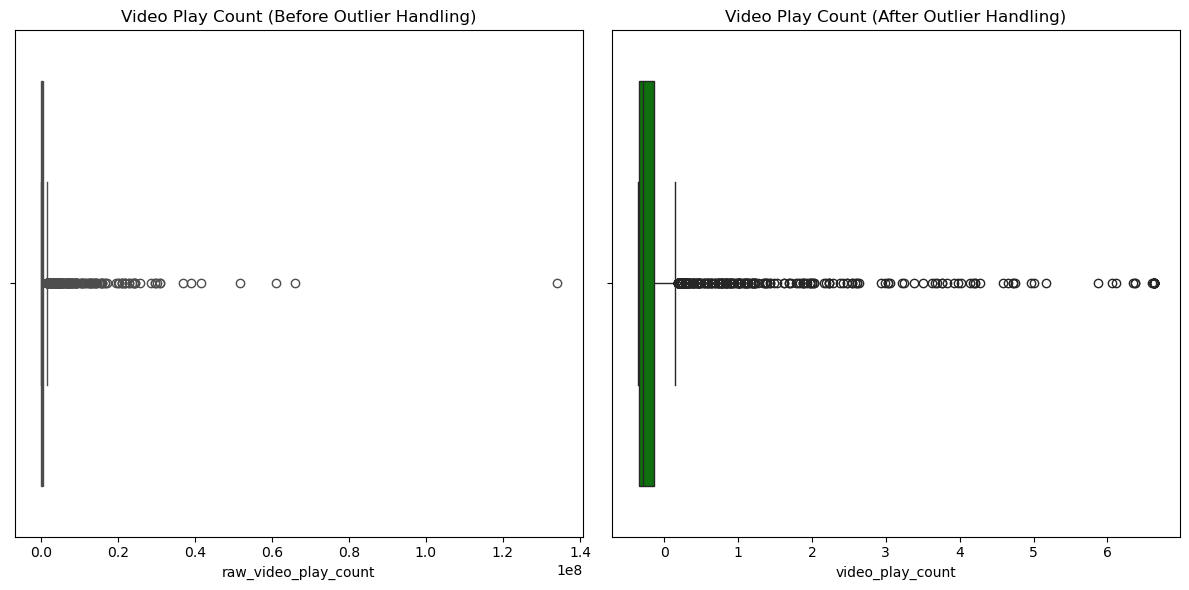

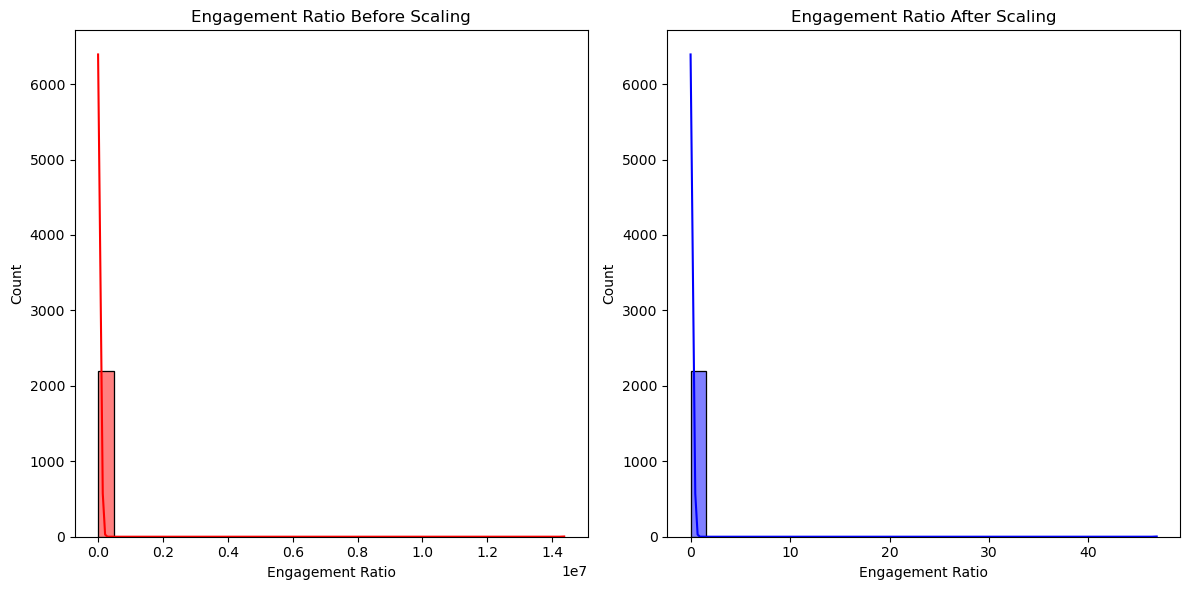

In [81]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_raw['raw_word_count'], kde=True, bins=30, color='blue')
plt.title('Word Count Before Preprocessing')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], kde=True, bins=30, color='green')
plt.title('Word Count After Preprocessing')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_raw['raw_video_play_count'], color='red')
plt.title('Video Play Count (Before Outlier Handling)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['video_play_count'], color='green')
plt.title('Video Play Count (After Outlier Handling)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_raw['raw_engagement_ratio'], kde=True, bins=30, color='red')
plt.title('Engagement Ratio Before Scaling')
plt.xlabel('Engagement Ratio')

plt.subplot(1, 2, 2)
sns.histplot(df['engagement_ratio'], kde=True, bins=30, color='blue')
plt.title('Engagement Ratio After Scaling')
plt.xlabel('Engagement Ratio')
plt.tight_layout()
plt.show()





Linear Regression MAE (Log Space): 0.2890594491289351
Linear Regression R² (Log Space): 0.030462878575079233
Random Forest MAE (Log Space): 0.30303098245768506
Random Forest R² (Log Space): -0.025846486294224036
XGBoost MAE (Log Space): 0.325382327037923
XGBoost R² (Log Space): -0.16774761483463774
Cross-Validated MAE for Linear Regression (Log Space): 0.2746106011198705
Cross-Validated MAE for Random Forest (Log Space): 0.26769568625433793
Cross-Validated MAE for XGBoost (Log Space): 0.2799480589990048


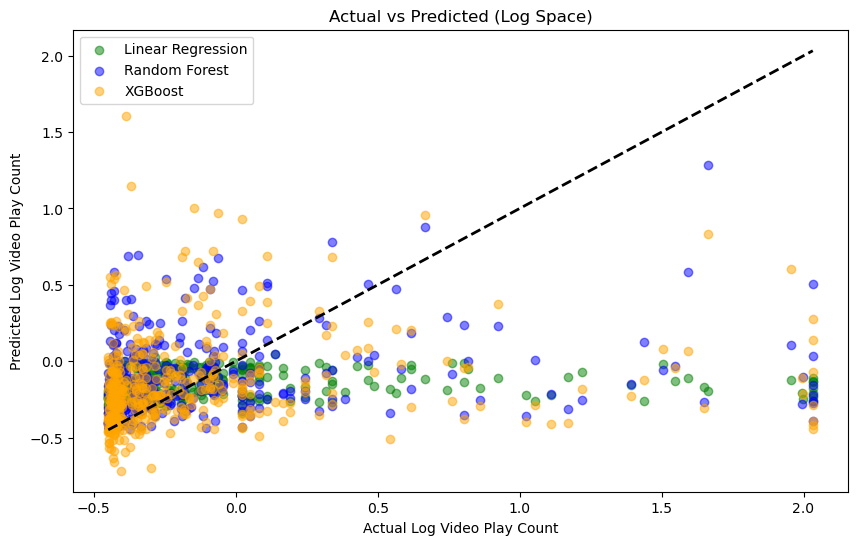

In [82]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df['log_video_play_count'] = np.log1p(df['video_play_count'])


features = df[['author_follower_count', 'sentiment_polarity', 'sentiment_subjectivity', 'topic', 'word_count', 'hour']]
target = df['log_video_play_count']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# standardlization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df['log_video_play_count'] = np.log1p(df['video_play_count'])
features = df[['author_follower_count', 'word_count', 'sentiment_polarity', 'sentiment_subjectivity', 'topic', 'hour']]
target = df['log_video_play_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_log_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_log_lr)
r2_lr = r2_score(y_test, y_pred_log_lr)
print(f'Linear Regression MAE (Log Space): {mae_lr}')
print(f'Linear Regression R² (Log Space): {r2_lr}')

# 2. Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_log_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_log_rf)
r2_rf = r2_score(y_test, y_pred_log_rf)
print(f'Random Forest MAE (Log Space): {mae_rf}')
print(f'Random Forest R² (Log Space): {r2_rf}')

# 3. XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_log_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_log_xgb)
r2_xgb = r2_score(y_test, y_pred_log_xgb)
print(f'XGBoost MAE (Log Space): {mae_xgb}')
print(f'XGBoost R² (Log Space): {r2_xgb}')


# Cross-validation for Linear Regression
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_lr = -cv_scores_lr.mean()
print(f"Cross-Validated MAE for Linear Regression (Log Space): {cv_mae_lr}")

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_rf = -cv_scores_rf.mean()
print(f"Cross-Validated MAE for Random Forest (Log Space): {cv_mae_rf}")

# Cross-validation for XGBoost
cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_xgb = -cv_scores_xgb.mean()
print(f"Cross-Validated MAE for XGBoost (Log Space): {cv_mae_xgb}")



# Visualize Actual vs Predicted values for Linear Regression, Random Forest, and XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_log_lr, alpha=0.5, label='Linear Regression', color='green')
plt.scatter(y_test, y_pred_log_rf, alpha=0.5, label='Random Forest', color='blue')
plt.scatter(y_test, y_pred_log_xgb, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Log Video Play Count')
plt.ylabel('Predicted Log Video Play Count')
plt.legend()
plt.title('Actual vs Predicted (Log Space)')
plt.show()

Normalized Weights for Features:
video_comment_count       0.312244
video_heart_count         0.353882
video_share_count         0.254338
sentiment_polarity        0.017234
sentiment_subjectivity    0.006131
word_count                0.056170
Name: video_play_count, dtype: float64


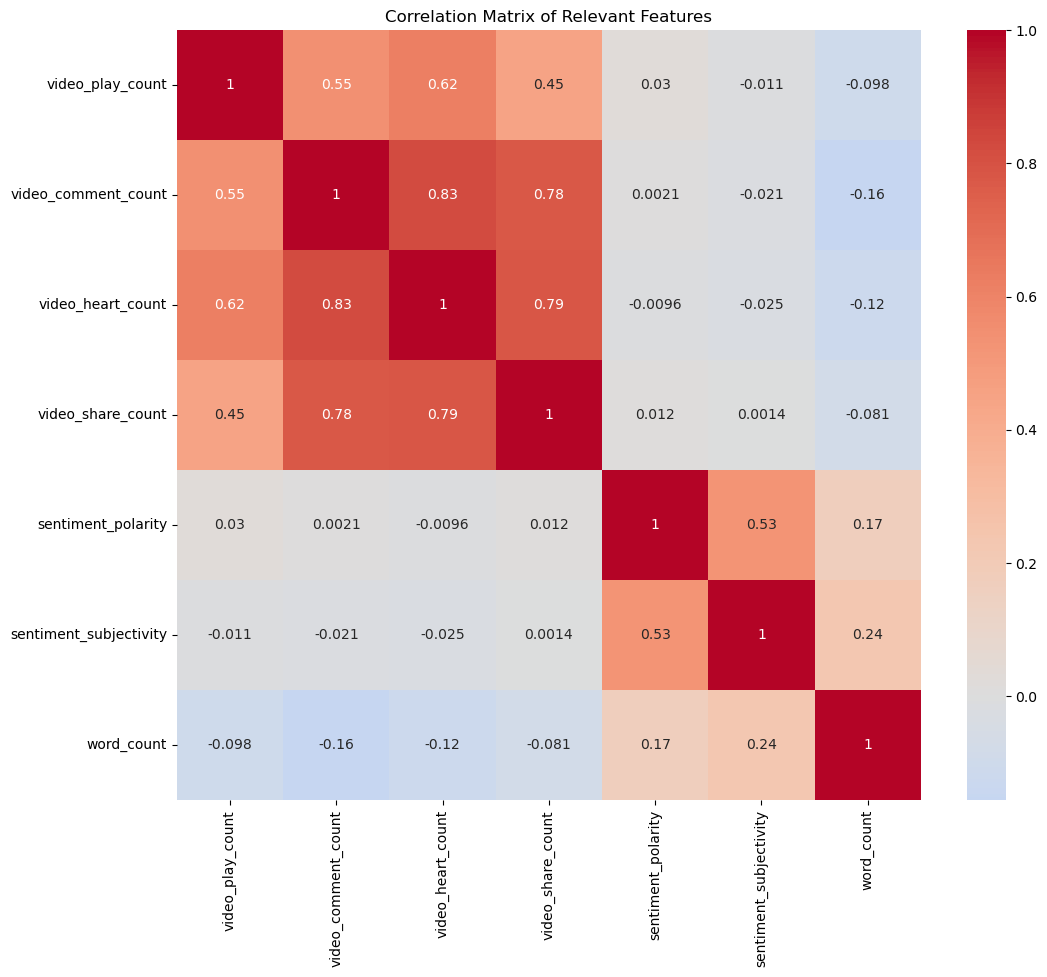

Random Forest (Log Space) - MAE: 0.06199567093473605, RMSE: 0.11517022223795971, R²: 0.9023428372417306
XGBoost (Log Space) - MAE: 0.058412364189407796, RMSE: 0.1130300962709845, R²: 0.9059385026791519
Cross-Validated MAE for Random Forest (Log Space): 0.061303095310978564
Cross-Validated MAE for XGBoost (Log Space): 0.06254347036467325


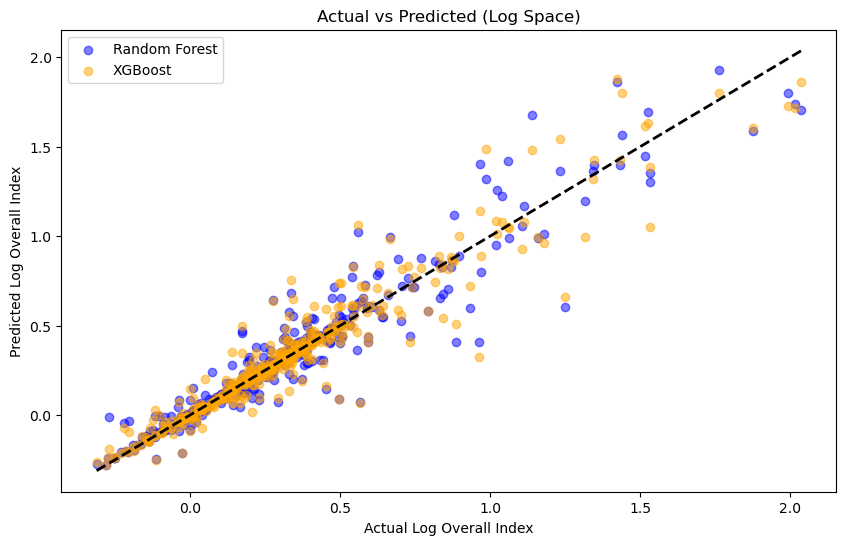

                  Feature  Importance
4     video_comment_count    0.728257
1              word_count    0.233858
5                    hour    0.014804
0   author_follower_count    0.011408
2      sentiment_polarity    0.005914
3  sentiment_subjectivity    0.005759


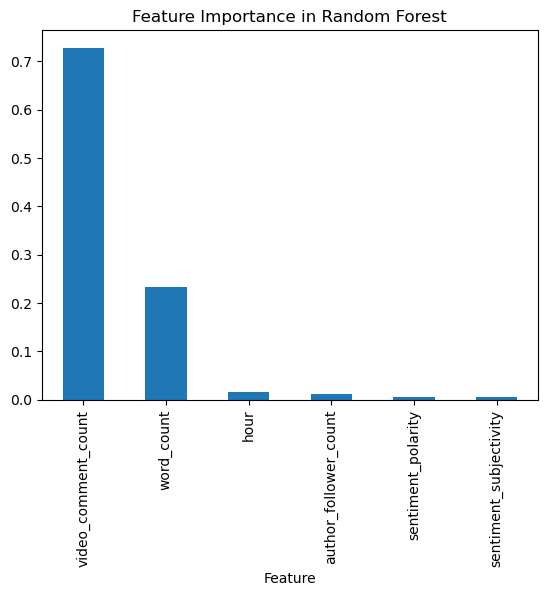

                  Feature  Importance
4     video_comment_count    0.594117
1              word_count    0.331039
0   author_follower_count    0.022413
5                    hour    0.020418
2      sentiment_polarity    0.016495
3  sentiment_subjectivity    0.015519


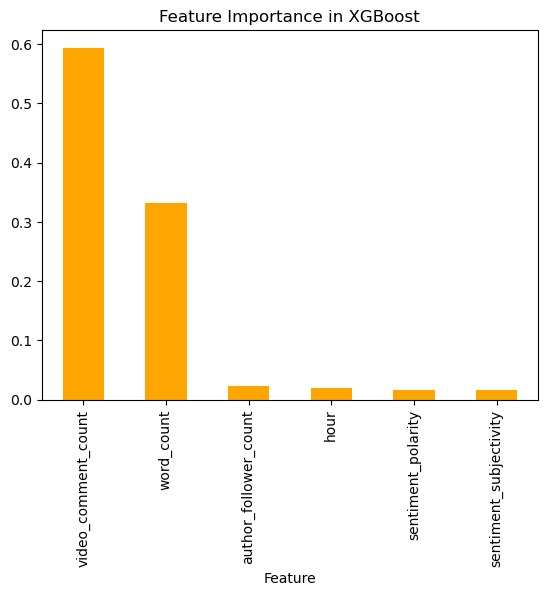

In [85]:
# comprehensive TikTok score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


relevant_features = ['video_play_count', 'video_comment_count', 'video_heart_count',
                     'video_share_count', 'sentiment_polarity', 'sentiment_subjectivity', 'word_count']

# Convert all relevant columns to numeric
for feature in relevant_features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

# Drop rows with missing or invalid values in the relevant features
df_cleaned = df.dropna(subset=relevant_features)

# Compute the correlation of relevant features with `video_play_count`
correlation_with_play_count = df_cleaned[relevant_features].corr()['video_play_count']

# Select relevant features and their correlations (ignoring `video_play_count` itself)
feature_correlations = correlation_with_play_count.drop('video_play_count')

# Normalize correlations to sum up to 1
normalized_weights = np.abs(feature_correlations) / np.abs(feature_correlations).sum()

# Print normalized weights for debugging
print("Normalized Weights for Features:")
print(normalized_weights)

# Compute the `overall_index` as a weighted sum of features
df_cleaned['overall_index'] = (
    df_cleaned['video_comment_count'] * normalized_weights['video_comment_count'] +
    df_cleaned['video_heart_count'] * normalized_weights['video_heart_count'] +
    df_cleaned['video_share_count'] * normalized_weights['video_share_count'] +
    df_cleaned['sentiment_polarity'] * normalized_weights['sentiment_polarity'] +
    df_cleaned['sentiment_subjectivity'] * normalized_weights['sentiment_subjectivity'] +
    df_cleaned['word_count'] * normalized_weights['word_count']
)

# Apply log transformation to the target variable
df_cleaned['log_overall_index'] = np.log1p(df_cleaned['overall_index'])

# Plot the correlation matrix
corr_matrix = df_cleaned[relevant_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Relevant Features')
plt.show()


features = df_cleaned[['author_follower_count', 'word_count', 'sentiment_polarity',
                       'sentiment_subjectivity', 'video_comment_count', 'hour']]
target = df_cleaned['log_overall_index']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_log_rf = rf_model.predict(X_test_scaled)

# XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_log_xgb = xgb_model.predict(X_test_scaled)

# mae
mae_rf = mean_absolute_error(y_test, y_pred_log_rf)
mae_xgb = mean_absolute_error(y_test, y_pred_log_xgb)

# rmse
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_log_rf))
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_log_xgb))

# r2
r2_rf = r2_score(y_test, y_pred_log_rf)
r2_xgb = r2_score(y_test, y_pred_log_xgb)

print(f"Random Forest (Log Space) - MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")
print(f"XGBoost (Log Space) - MAE: {mae_xgb}, RMSE: {rmse_xgb}, R²: {r2_xgb}")

# Cross-validated MAE for both models
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_rf = -cv_scores_rf.mean()

cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_xgb = -cv_scores_xgb.mean()

print(f"Cross-Validated MAE for Random Forest (Log Space): {cv_mae_rf}")
print(f"Cross-Validated MAE for XGBoost (Log Space): {cv_mae_xgb}")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_log_rf, alpha=0.5, label='Random Forest', color='blue')
plt.scatter(y_test, y_pred_log_xgb, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Log Overall Index')
plt.ylabel('Predicted Log Overall Index')
plt.legend()
plt.title('Actual vs Predicted (Log Space)')
plt.show()

# Feature importance visualization Random Forest
feature_importances_rf = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances_rf)

# feature importance for Random Forest
feature_importances_rf.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance in Random Forest')
plt.show()

# Feature importance visualization XGBoost
feature_importances_xgb = pd.DataFrame({
    'Feature': features.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances_xgb)

# feature importance for XGBoost
feature_importances_xgb.plot(kind='bar', x='Feature', y='Importance', legend=False, color='orange')
plt.title('Feature Importance in XGBoost')
plt.show()
